In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import math
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
DF = pd.read_csv("yle_ehdokkaat.csv",skiprows=0)

In [3]:
# EXPERIMENTAL STUFF
def clean(x):
    """Parse elements into integers of 1-5. Anomalies are treated as a 0 or 'skip'."""
    if type(x) != float and not x.isdigit():
        return 0
    elif x == float('nan'):
        return 0
    elif math.isnan(float(x)):
        return 0
    else:
        return int(x)
    
# Make into element-wise function
vclean = np.vectorize(clean)


def filter_blanks(df_region):
    """Return a copy of the input DataFrame without empty rows."""
    temp_mat = vclean(df_region.to_numpy()[:,3:])
    removables_by_index = []
    for i,j in enumerate(temp_mat):
        if np.sum(j) == 0: removables_by_index.append(i)
            
    removables = [df_region.index[idx] for idx in removables_by_index]
    # print("Removing {} empty rows from {}".format(len(removables),df_region.iloc[0][0]))
    return df_region.drop(removables)

def to_dict_mat(df_clean_region):
    mat = vclean(df_clean_region.to_numpy()[:,3:])
    ids = list(df_clean_region.index)
    a,b,c = zip(*df_clean_region.to_numpy()[:,:3])
    d = {j:(a[i],b[i],c[i]) for i,j in enumerate(ids)} 
    return ids, d, mat

def general_dict(regions):
    d = {}
    x = np.sum(np.asarray([x.shape[0] for x in regions]))
    ids = []
    mats = []
    for r in regions:
        cand_ids,D,M = to_dict_mat(r)
        mats.append(M)
        ids.append(cand_ids)
        for a,b in D.items():
            d[a] = b 
    return ids,d,np.concatenate(mats)

def clean_data(df):
    l = []
    regions = np.unique(df.vaalipiiri)
    for piiri in np.unique(df.vaalipiiri):
        # print(piiri)
        # 1) Filter out completely Nan rows
        piiri_df = df[df.vaalipiiri == piiri].dropna(axis=1,how='all')

        # 2) Get columns contain only text answers
        removable_cols = list(piiri_df.columns[range(32,82)]) + [col for col in piiri_df.columns if col[-1] == "1"]
        
        # 3) Remove semi-manually 4 questions that were removed afterwards
        removed_questions = ["Energiajuomien myyminen alle", "Nuuskan, purutupakan ja", "On olemassa pyhiä tai muuten", "On oikein nähdä vaivaa sen eteen"]
        
        for que in removed_questions:
            for col in piiri_df.columns:
                if que in col: removable_cols.append(col) 
        
        # 4) Drop those columns and add dataframe to `l` 
        dropped = piiri_df.drop(removable_cols,axis="columns")
        l.append(filter_blanks(dropped))
    
    ids,d,mats = general_dict(l)
    flattened_ids = np.asarray([x for z in ids for x in z])
    m = np.column_stack((flattened_ids,mats))
    return ids,d, m,regions

def Msub(ids,m,reg_idx):
    start = 0
    for i in range(reg_idx): start+= len(ids[i])
    end = start+len(ids[reg_idx])
    return m[start:end]

def get_ids(m):
    return m[:,0].astype(int)

def e(D,cand):
    return 1 if D[cand][2] in [1,2] else 0
    

In [4]:
IDS,D,M,REGIONS = clean_data(DF)

RIDX = list(range(len(IDS)))
M_regs = [Msub(IDS,M,i) for i in RIDX]
N_CANDS = M.shape[0] # 2263
RWEIGHTS = np.asarray([len(x) for x in IDS]) / np.sum(np.asarray([len(x) for x in IDS]))
ELECTED_RATIO = sum([1 for i,c in D.items() if c[2] == 1]) / len(D.items())
PARTIES = np.unique(DF.puolue)
print(REGIONS)

['Ahvenanmaan maakunnan vaalipiiri' 'Helsingin vaalipiiri'
 'Hämeen vaalipiiri' 'Kaakkois-Suomen vaalipiiri'
 'Keski-Suomen vaalipiiri' 'Lapin vaalipiiri' 'Oulun vaalipiiri'
 'Pirkanmaan vaalipiiri' 'Satakunnan vaalipiiri'
 'Savo-Karjalan vaalipiiri' 'Uudenmaan vaalipiiri' 'Vaasan vaalipiiri'
 'Varsinais-Suomen vaalipiiri']


In [5]:
def distance_check(i,j,B):
    return B[i,j]

vdc = np.vectorize(distance_check) # Vectorized element distance look-up for FAST SPEEDS
vdc.excluded.add(2)

def distance(i,j,M, B,norm,skip_policy):
    """Return the scalar distance between rows `i` and `j` (not equal) of `M`, using mapping `A`
    for the row elements, `norm` for the norm and a pre-defined 'skip_policy'. Pairs of elements
    of M[i] and M[j] are mapped to a specific distance in A[i,j]. A pre-determined A and
    skip_policy lets one create arbitrary distance functions.
    """

    assert M[i].shape == M[j].shape, "M[i].shape is not M[j].shape"
    assert skip_policy in ["user_first","soft_skip","hard_skip"], "Skip policy not defined"
    
    # If "user_first", assume i = user, j = candidate
    
    # skip_filter determines which answer pairs ARE NOT SKIPPED (needed for normalization)
    
    if skip_policy == "user_first":
        skip_filter = M[i] != 0 # Remember that i = user
    elif skip_policy == "soft_skip":
        skip_filter = np.logical_or(M[i] != 0, M[j] != 0)
    elif skip_policy == "hard_skip":
        skip_filter = np.logical_and(M[i] != 0, M[j] != 0)
    
    
    # Normalizing
    v = vdc(M[i],M[j],B)[skip_filter]
    z = ((np.sum(v**norm))**(1/norm) ) /(v.shape[0])
    if np.isnan(z): print(M[i],M[j])
    return z
# REGARDING DISTANCE METRIC
# Three skip policies
# "user_first": - If candidate skips but user doesn't --> Max dist
#               - If user skips --> Skip question

# "soft_skip" : - If either skips --> Skip question

# "hard_skip" : - If one skips --> Max dist
#               - If both skip --> Skip question


# Defining distance matrices

In [6]:
# This part is referred to in thesis.


# Traditional 5-point Likert scale
B_5 = np.asarray( # 5-point Likert
[[999,   1,   1,   1,   1,  1], 
 [  1,   0, .25,  .5, .75,  1],
 [  1, .25,   0, .25,  .5,.75],
 [  1,  .5, .25,   0, .25, .5],
 [  1, .75,  .5, .25,   0,.25],
 [  1,   1, .75,  .5, .25,  0],
])

# Mapping from 5-point to a 3-point Likert scale
B_3 = np.asarray(
[[999,   1,   1,   1,   1,  1],
 [  1,   0,   0,  .5,   1,  1],
 [  1,   0,   0,  .5,   1,  1],
 [  1,  .5,  .5,   0,  .5, .5],
 [  1,   1,   1,  .5,   0,  0],
 [  1,   1,   1,  .5,   0,  0],
])


# Binary distance mapping
# (1,2) -> 0
# (2,3) -> 1
# (1,5) -> 1
# (2,4) -> 1

B_2 = np.asarray( 
[[999,   1,   1,   1,   1,  1],
 [  1,   0,   0,   1,   1,  1],
 [  1,   0,   0,   1,   1,  1],
 [  1,   1,   1,   0,   1,  1],
 [  1,   1,   1,   1,   0,  0],
 [  1,   1,   1,   1,   0,  0],
])

B_dir = np.asarray(
[[999,   1,    1,   1,   1,  1],
 [  1,   0,  .25,  .5, .75,  1],
 [  1, .25, .375,  .5,.625,.75],
 [  1,  .5,   .5,  .5,  .5, .5],
 [  1, .75, .625,  .5,.375,.25],
 [  1,   1,  .75,  .5, .25,  0],
])

B_hyb = np.asarray( 
[[999,   1,    1,   1,    1,  1],
 [  1,   0,  .25,  .5,  .75,  1],
 [  1, .25,.1875,.375,.5625,.75],
 [  1,  .5, .375, .25, .375, .5],
 [  1, .75,.5625,.375,.1875,.25],
 [  1,   1,  .75,  .5,  .25,  0],
])

Bs = [B_5, B_3, B_2, B_dir, B_hyb]

# Creating a graph

In [7]:
# Given a matrix filled with answers and a distance function (with parameters),
# returns a fully connected weighted graph 

def create_fully_connected(M,B,norm, skip_policy):
    """Return a fully-connected weighted graph (nx.Graph) based on given value matrix M,
    distance matrix A and specific skip_policy string.
    """
    
    g = nx.Graph()
    edges = []
    for i in range(M.shape[0]):
        for j in range(M.shape[0]): 
            if i != j: edges.append(  (M[i,0],M[j,0], distance(i,j,M[:,1:], B, norm, skip_policy) )   )
    g.add_weighted_edges_from(edges)
    return g

# Outputs a subgraph of G, that contains the MST of G + m-V(MST(G))*p strongest edges
def MST_and_p(g,p):
    """Return a subpgraph of parameter g, that contains the MST of G + m-V(MST(G))*p strongest edges."""
    
    mst = nx.minimum_spanning_tree(g)
    g_edges = sorted(g.edges(data='weight'),key = lambda x: x[2])
    mst_edges = mst.edges(data='weight')
    g_edges_filtered = [e for e in g_edges if e not in mst_edges]    
    mst.add_weighted_edges_from( g_edges_filtered[:int(len(g_edges_filtered)*p)] )

    return mst

def create_graph(M_reg,B,norm,skip_policy,p,graph_name=None):
    """Return a graph for given regional value Matrix M_reg, 
     distance matrix A and specific skip_policy string, and edge-ratio p. 
    """
    
    print(f"Creating graph with {M_reg.shape[0]} nodes and r={p}")
    g = create_fully_connected(M_reg,B,norm, skip_policy)
    g1 = MST_and_p(g,p) if p < 1 else g
    
    if graph_name:
        nx.write_edgelist(g1, f"graphs/{graph_name}.edgelist")
        print(f"Saved {graph_name}.edgelist to /graphs/")
    
    return g1


# Centrality measures

In [8]:
# Given a graph, calculates the centrality measures for each node and returns them in
# a dict in form {cand_id : (closeness,clustering,betweenness,eignevector) }

def cents_per_node(g):
    """Return weighted graph g centrality measures (close,clust,betw,eig) as a dictionary."""
    d_close = nx.closeness_centrality(g,distance='weight')
    d_clust = nx.clustering(g,weight='weight')
    d_betw = nx.betweenness_centrality(g, k=None, weight='weight')
    try:
        d_eig = nx.eigenvector_centrality(g,max_iter=1000,weight='weight')
    except nx.PowerIterationFailedConvergence:
        print("Eigenvectorcentrality failed to converge, replacing with -1's")
        d_eig = {n:-1 for n in g.nodes}
    d_deg = nx.degree_centrality(g)
    return {a:(d_deg[a], d_close[a], d_clust[a], d_betw[a], d_eig[a])  for a,b in d_close.items()}

# Major question 1)
def cents_per_region(M_regs,B,norm,skip_policy,p,graph_name):
    """Return within region centrality measures for all regions and candidates."""
    d_cent = {}
    for i,M_reg in enumerate(M_regs):
        name = None if not graph_name else graph_name + "_reg" + str(i)
        g = create_graph(M_reg,B,norm,skip_policy,p,name)
        d_cent = {**d_cent,**cents_per_node(g)}
    return d_cent

# Takes a dictionary of form {candidate_id : (closeness,clustering,betweenness,eignevector) }
# And creates a Pandas DataFrame in form of 
#      close clust betws eigen elect
# cand1  x     x     x    x      x  
# cand2  x     x     x    x      x  

# Major question 2)
def cents_per_party(D,M_regs,B,norm,skip_policy):
    """Return within region within party centrality measures for all regions and candidates."""
    d_cent = {}
    d_table = D.items()
    
    for reg_idx,M_reg in enumerate(M_regs):
        present_parties = set([b[1] for a,b in d_table if b[0] == REGIONS[reg_idx]])
        d_table_party = [entry for entry in d_table if entry  ]
        g = create_fully_connected(M_reg,B,norm, skip_policy)
        d_region = {}
        for i,j in enumerate([p for p in PARTIES if p in present_parties]):
            party_nodes = [a for a,b in d_table if b[0]==REGIONS[reg_idx] and b[1]==j]
            g_part = g.subgraph(party_nodes)
            # print(i,j,party_nodes)
            if party_nodes: d_region = {**d_region,**cents_per_node(g_part)}
        d_cent = {**d_cent,**d_region}
    return d_cent


"""def d_to_df(d_cent):
    #Return input dictionary as a pandas DataFrame.
    table = []
    for a,b in d_cent.items():
        el = [e(D,cand)]
        z =  list(b) + el
        # if a in IDS[1]: table.append(z )
        table.append(z)
    labels = ['closeness','clustering','betweenness','eigenvector','elected']
    return pd.DataFrame.from_records(table,columns=labels)"""
""


''

# Determine p

In [9]:
CENTRALITIES = labels = ['degree','closeness','clustering','betweenness','eigenvector']

In [61]:
import time
# Test a good value for p with B_5 and 1-norm and cents for helsinki region
ps = np.linspace(0,1,21)
results = []
times = []

for p in ps:
    start = time.time()
    degs,closes,clusts,betws,eigs = zip(*cents_per_region([M_regs[1]],Bs[0],1,"soft_skip",p,None).values())
    end = time.time()
    results.append( [np.mean(degs), np.mean(closes),np.mean(clusts),np.mean(betws),np.mean(eigs),end-start] )

Creating graph with 262 nodes and p=0.0
Creating graph with 262 nodes and p=0.05
Creating graph with 262 nodes and p=0.1
Creating graph with 262 nodes and p=0.15000000000000002
Creating graph with 262 nodes and p=0.2
Creating graph with 262 nodes and p=0.25
Creating graph with 262 nodes and p=0.30000000000000004
Creating graph with 262 nodes and p=0.35000000000000003
Creating graph with 262 nodes and p=0.4
Creating graph with 262 nodes and p=0.45
Creating graph with 262 nodes and p=0.5
Creating graph with 262 nodes and p=0.55
Creating graph with 262 nodes and p=0.6000000000000001
Creating graph with 262 nodes and p=0.65
Creating graph with 262 nodes and p=0.7000000000000001
Creating graph with 262 nodes and p=0.75
Creating graph with 262 nodes and p=0.8
Creating graph with 262 nodes and p=0.8500000000000001
Creating graph with 262 nodes and p=0.9
Creating graph with 262 nodes and p=0.9500000000000001
Creating graph with 262 nodes and p=1.0


In [59]:
results_arr = np.asarray(results)

for i in range(len(results_arr[0])):
    results_arr[:,i] = results_arr[:,i]/np.max(results_arr[:,i])

markers = [".-","o-","v-","s-","+-","x-"]
temp_labels = CENTRALITIES + ["Runtime"]
for i in range(len(results_arr[0])):
    plt.plot(ps,results_arr[:,i],markers[i],label=temp_labels[i])
plt.legend()
plt.title("Average centrality measures for different values of r")
plt.ylabel("Average value normalized by maximum value")
plt.xlabel("Approx. ratio of edges in graph (r)")
plt.savefig("ps_centralities.pdf")

NameError: name 'results' is not defined

# Now we have all the calculatory tools ready

What we want to do is find differences in centrality measures between candidates who were elected and not. We are going to use the soft_skip policy, i.e. an element if the VAA is skipped between to candidates, if either of them skipped it. Note: We are using $p=0.2$ because of the speedup it gives.

In [10]:
P = 0.3
policy = "soft_skip"
B_labels = ["5-point","3-point","Binary","Directional","Hybrid"]
CENTRALITIES = labels = ['degree','closeness','clustering','betweenness','eigenvector']

In [12]:
inp = input("Read/Write/None? (r/w/n)").lower()
dest = "regionals.csv"
df_columns = ["cand","c_value","centrality","B","norm","elected"]

if inp == "r":
    print(f"DataFrame loaded to df_reg from {dest}")
    df_reg = pd.read_csv(dest,usecols=df_columns)
else:
    
    # Takes quite a while to crunch the 10 regional things
    # A large p makes things a lot slower
    regionals = []
    for i,B in enumerate(Bs):
        print(f"Calculating centralities for {B_labels[i]} ({(i+1)}/{len(Bs)})")
        graph_name = f"b{i}"
        regionals.append((i,1,cents_per_region(M_regs,B,1,policy,P,graph_name + "_n1")))
        regionals.append((i,2,cents_per_region(M_regs,B,2,policy,P,graph_name + "_n2")))

    temp_table = []
    for b,n,d_cents in regionals:
        for cand,cents in d_cents.items():
            for ci,c in enumerate(cents):
                temp_table.append( [cand,c,ci,b,n,e(D,cand)] )
    # df_long_labels = ["cand","c_value","centrality","a","norm","elected"]
    df_reg = pd.DataFrame.from_records(temp_table,columns = df_columns)
    
    if inp == "w":
        df_reg.to_csv(dest,columns = df_columns)
        print(f"Saved to {os.getcwd()}/{dest}")
display(df_reg.head(5))

Read/Write/None? (r/w/n)r
DataFrame loaded to df_reg from regionals.csv


cand   c_value  centrality  B  norm  elected
0  1070  0.750000           0  0     1        1
1  1070  3.137255           1  0     1        1
2  1070  0.251106           2  0     1        1
3  1070  0.666667           3  0     1        1
4  1070  0.652012           4  0     1        1

# Same with party regionals

In [13]:
inp = input("Read/Write/None? (r/w/n)").lower()
dest = "party_regionals.csv"
df_columns = ["cand","c_value","centrality","B","norm","elected"]

if inp == "r":
    print(f"DataFrame loaded to df_reg from {dest}")
    df_party = pd.read_csv(dest,usecols=df_columns)
else:
    # Takes quite a while
    # A large p makes things a lot slower
    party_reg = []
    for i,B in enumerate(Bs):
        print(f"Calculating centralities for {B_labels[i]} ({(i+1)}/{len(Bs)})")
        party_reg.append((i,1,cents_per_party(D,M_regs,B,1,policy)))
        party_reg.append((i,2,cents_per_party(D,M_regs,B,2,policy)))

    temp_table = []
    for b,n,d_cents in party_reg:
        for cand,cents in d_cents.items():
            for ci,c in enumerate(cents):
                temp_table.append( [cand,c,ci,b,n,e(D,cand)] )
    # df_long_labels = ["cand","c_value","centrality","a","norm","elected"]
    df_party = pd.DataFrame.from_records(temp_table,columns = df_columns)
    
    if inp == "w":
        df_party.to_csv(dest,columns = df_columns)
        print(f"Saved to {os.getcwd()}/{dest}")
display(df_party.head(5))

Read/Write/None? (r/w/n)r
DataFrame loaded to df_reg from party_regionals.csv


cand   c_value  centrality  B  norm  elected
0  1070  1.000000           0  0     1        1
1  1070  3.178808           1  0     1        1
2  1070  0.625515           2  0     1        1
3  1070  0.000000           3  0     1        1
4  1070  0.422163           4  0     1        1

/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


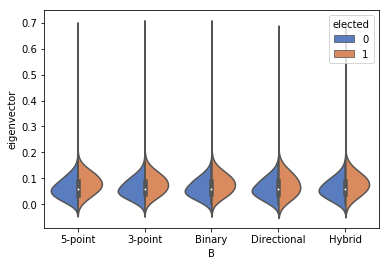

In [14]:
# Regional centrality measures
for i,c in enumerate(CENTRALITIES):
    g = sns.violinplot(x="B", y="c_value", hue="elected",
                       data=df_reg[df_reg.centrality == i][df_reg.norm == 1], palette="muted", split=True,bw=.5)
    plt.ylabel(CENTRALITIES[i])
    plt.xticks(np.arange(len(B_labels)), B_labels)
    plt.savefig(f"region_{c}.pdf")
    plt.show()

In [15]:
# Welch's t-test for regions
from scipy import stats

t_table = np.zeros((len(CENTRALITIES),len(B_labels)))
p_table = np.zeros((len(CENTRALITIES),len(B_labels)))


for i,c in enumerate(CENTRALITIES):
    for j,b in enumerate(B_labels):
        df_temp = df_reg[df_reg.centrality == i][df_reg.B == j]
        df_elec, df_nelec = df_temp[df_temp.elected == 1], df_temp[df_temp.elected == 0]
    
        t,p = stats.ttest_ind(df_elec.c_value, df_nelec.c_value ,equal_var=False)
        t_table[i,j] = t
        p_table[i,j] = p

df_reg_ps = pd.DataFrame(p_table,index=CENTRALITIES,columns=B_labels)
df_reg_ps.to_csv("regional_p.csv",columns = B_labels)

/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from 

/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


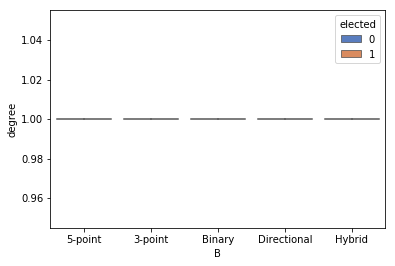

/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


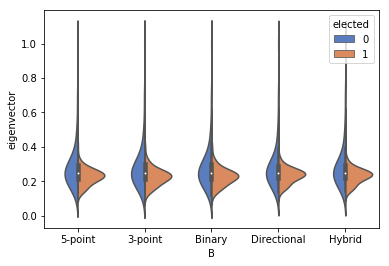

In [16]:
# Plot party centrality measures with different norms
for i,c in enumerate(CENTRALITIES):
    g = sns.violinplot(x="B", y="c_value", hue="elected",
                       data=df_party[df_party.centrality == i][df_reg.norm == 1], palette="muted", split=True,bw=.5)
    plt.ylabel(CENTRALITIES[i])
    plt.xticks(np.arange(len(B_labels)), B_labels)
    plt.savefig(f"party_{c}.pdf")
    plt.show()


In [17]:
# Welch's t-test for parties
t_table = np.zeros((len(CENTRALITIES),len(B_labels)))
p_table = np.zeros((len(CENTRALITIES),len(B_labels)))

for i,c in enumerate(CENTRALITIES):
    for j,b in enumerate(B_labels):
        df_temp = df_party[df_party.centrality == i][df_party.B == j]
        df_elec,df_nelec = df_temp[df_temp.elected == 1],df_temp[df_temp.elected == 0]
        t,p = stats.ttest_ind(df_elec.c_value,df_nelec.c_value,equal_var = False)
        t_table[i,j] = t
        p_table[i,j] = p

df_party_ps = pd.DataFrame(p_table,index=CENTRALITIES,columns=B_labels)
display(df_party_ps)
df_party_ps.to_csv("party_p.csv",columns = B_labels)

/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/monsu/anac

5-point       3-point        Binary   Directional  \
degree                NaN           NaN           NaN           NaN   
closeness    3.748518e-04  4.976596e-04  4.976596e-04  2.870518e-02   
clustering   4.284930e-03  2.481341e-02  2.481341e-02  4.116547e-04   
betweenness  2.962761e-02  4.198062e-01  4.198062e-01           NaN   
eigenvector  8.198250e-75  1.103136e-71  1.103136e-71  2.988882e-67   

                   Hybrid  
degree                NaN  
closeness    3.804313e-03  
clustering   7.079940e-01  
betweenness           NaN  
eigenvector  7.687852e-72

# Draw satakunta to present colours

In [18]:
g = create_graph(M_regs[8],B_5,1,policy,P)

Creating graph with 103 nodes and p=0.3


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


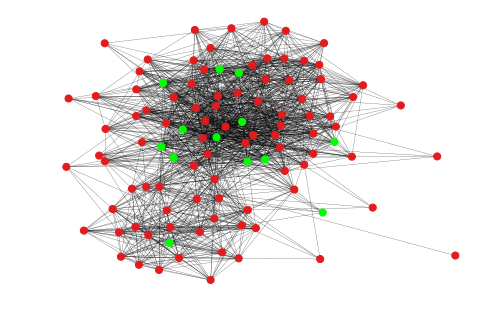

In [19]:
set1 = plt.cm.get_cmap('Set1', 3)
new_colors = set1.colors
blue = np.array([(0,1,0,1)])
new_colors[2] = blue
newcmp = ListedColormap(new_colors)

node_labels = [e(D,n) for n in g.nodes]
nx.draw_kamada_kawai(g,node_size=50,width=0.2,node_color=node_labels,cmap=newcmp,label="yes")
# plt.legend([0,1],["yes","y"])
plt.savefig("draw_satakunta.pdf")



# Draw answer  type frequency distribution

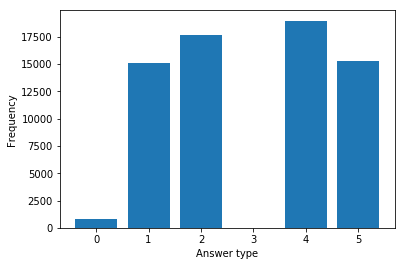

In [21]:
rows =  [row  for M_reg in M_regs for row in M_reg]
unique_elements, counts_elements = np.unique(np.asarray(rows)[:,1:], return_counts=True)

plt.bar(unique_elements,counts_elements)
plt.xlabel("Answer type")
plt.ylabel("Frequency")
plt.savefig("answer_freq_dist.pdf")


In [22]:
counts_elements/np.sum(counts_elements)

array([0.0123435 , 0.22262483, 0.26034762, 0.27934895, 0.2253351 ])

# Distributions of means and variances between elected/not

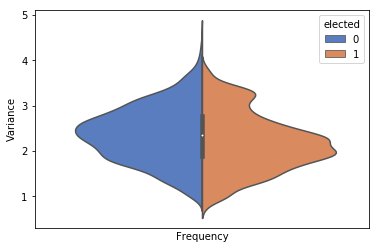

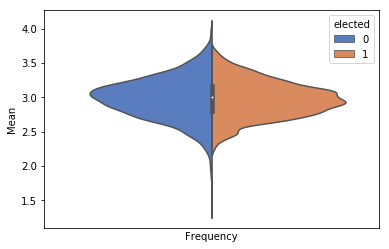

2.3736178180192304
2.9892521797451344
2.190137373737373
2.973939393939393
Welch's p-score for variances 9.890654987321848e-06
Welch's p-score for means 0.3729261709613897


0.3729261709613897

In [23]:
variances = np.var(np.asarray(rows)[:,1:], axis=1)
means = np.mean(np.asarray(rows)[:,1:], axis=1)

elected_vars = [v for i,v in enumerate(variances) if e(D,rows[i][0])]
non_elected_vars = [v for i,v in enumerate(variances) if not e(D,rows[i][0])]



records = [(0,variances[i],means[i],e(D,rows[i][0])) for i,j in enumerate(rows)]


col_labels = ["_","Variance","Mean","elected"]
df_answers = pd.DataFrame.from_records(records,columns=col_labels)
# display(df_vars[:5])


sns.violinplot(x="_",y="Variance",
                    data=df_answers,palette="muted",hue="elected",split=True,bw=.2)
plt.xticks([])
plt.xlabel("Frequency")

plt.savefig("variance_violin.pdf")
plt.show()

sns.violinplot(x="_",y="Mean",
                    data=df_answers,palette="muted",hue="elected",split=True,bw=.2)
plt.xticks([])
plt.xlabel("Frequency")
plt.savefig("mean_violin.pdf")
plt.show()


t,p = stats.ttest_ind(df_answers[df_answers.elected==0].Variance,
                      df_answers[df_answers.elected==1].Variance, equal_var = False)

print(df_answers[df_answers.elected==0].Variance.mean())
print(df_answers[df_answers.elected==0].Mean.mean())

print(df_answers[df_answers.elected==1].Variance.mean())
print(df_answers[df_answers.elected==1].Mean.mean())

print(f"Welch's p-score for variances {p}")

t,p = stats.ttest_ind(df_answers[df_answers.elected==0].Mean,
                      df_answers[df_answers.elected==1].Mean, equal_var = False)
print(f"Welch's p-score for means {p}")

p



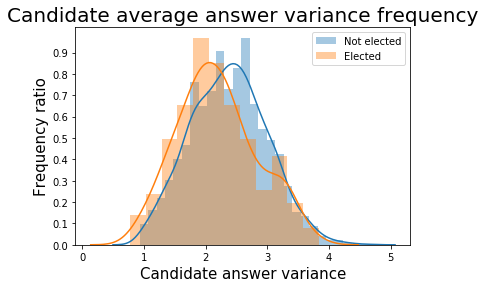

In [317]:
# display(df_answers)
# sns.kdeplot(df_answers[df_answers.elected==0].Variance,label="Not elected",bw=0.05,hist=True)
sns.distplot(df_answers[df_answers.elected==0].Variance,label="Not elected",hist=True,kde=True)
sns.distplot(df_answers[df_answers.elected==1].Variance,label="Elected",hist=True,kde=True)
plt.title("Candidate average answer variance frequency",size=20)
plt.xlabel("Candidate answer variance",size=15)
plt.yticks(np.linspace(0,0.65,10),[round(x,1) for x in np.arange(0,1.1,0.1)])
plt.ylabel("Frequency ratio",size=15)
plt.legend()
plt.savefig("kde_variance.pdf",bbox_inches='tight')
plt.show()


sns.distplot(df_answers[df_answers.elected==0].Mean,label="Not elected",hist=True,kde=True)
sns.distplot(df_answers[df_answers.elected==1].Mean,label="Elected",hist=True,kde=True)
plt.title("Candidate average answer mean frequency",size=20)
plt.xlabel("Candidate answer mean",size=15)
plt.yticks(np.linspace(0,1.5,10),[round(x,1) for x in np.linspace(0,1.0,11)])
plt.ylabel("Frequency ratio",size=15)
plt.legend()
plt.savefig("kde_mean.pdf",bbox_inches='tight')
plt.show()


In [155]:
display(df_reg[:5])

cand   c_value  centrality  B  norm  elected
0  1070  0.750000           0  0     1        1
1  1070  3.137255           1  0     1        1
2  1070  0.251106           2  0     1        1
3  1070  0.666667           3  0     1        1
4  1070  0.652012           4  0     1        1

In [209]:
# Add region index to df_temp
df_temp = df_reg[df_reg.centrality==4][df_reg.B==0][df_reg.norm==1]
region_row = [list(REGIONS).index(D[c][0]) for c in df_temp.to_numpy()[:,0]]
df_temp['ridx'] = region_row

fig, ax = plt.subplots(figsize=(20,8))

sns.violinplot(x='ridx',y='c_value',data=df_temp[5:],split=True,hue='elected')
region_labels = ['Ahvenanmaa', 'Helsinki', 'Häme', 'Kaakkois-Suomi', 'Keski-Suomi', 'Lappi',
                'Oulu', 'Pirkanmaa', 'Satakunta', 'Savo-Karjala', 'Uusimaa', 'Vaasa', 'Varsinais-Suomi']

plt.xticks(np.arange(0,12),region_labels[1:],rotation=60,size=20)
plt.yticks(size=20)
plt.legend(prop={'size': 20})
plt.title('Eigenvector centrality distributions between regions',size=30)
plt.xlabel('Election Region',size=20)
plt.ylabel('Eigenvector Centrality',size=20)
plt.savefig("region_eigenvectors.pdf",bbox_inches='tight')

/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# More advanced visuals

In [51]:


M_reg = M_regs[1]
cands = df_reg[df_reg.cand.isin(M_reg[:,0])][df_reg.norm==1][df_reg.centrality==4][df_reg.B==0] # Filter
temp_d = {}

for M_reg in M_regs:
    cands = df_reg[df_reg.cand.isin(M_reg[:,0])][df_reg.norm==1][df_reg.centrality==4][df_reg.B==0] # Filter
    for row in cands.to_numpy():
        key = int(row[0])
        temp_d[key] = tuple(list(D[key]) + [row[1]])
    cands = df_reg[df_reg.cand.isin(M_reg[:,0])][df_reg.norm==1][df_reg.centrality==2][df_reg.B==0]
    for row in cands.to_numpy():
        key = int(row[0])
        temp_d[key] = tuple(list(temp_d[key]) + [row[1]])
temp_d

/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/monsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be rein

{1070: ('Ahvenanmaan maakunnan vaalipiiri',
  'Sitoutumaton',
  2,
  0.6520124147700975,
  0.2511062090972888),
 1071: ('Ahvenanmaan maakunnan vaalipiiri',
  'Sitoutumaton',
  0,
  0.503895414304649,
  0.7533186272918665),
 1072: ('Ahvenanmaan maakunnan vaalipiiri',
  'Sitoutumaton',
  0,
  0.4889450469542168,
  0.7533186272918665),
 1073: ('Ahvenanmaan maakunnan vaalipiiri',
  'Sitoutumaton',
  1,
  0.26662086449893363,
  0.0),
 1074: ('Ahvenanmaan maakunnan vaalipiiri',
  'Sitoutumaton',
  0,
  0.10399652927474344,
  0.0),
 488: ('Helsingin vaalipiiri',
  'Perussuomalaiset',
  0,
  0.005678779413600624,
  0.4686249780026646),
 489: ('Helsingin vaalipiiri',
  'Vasemmistoliitto',
  0,
  0.0665807356768594,
  0.35341036499265044),
 490: ('Helsingin vaalipiiri',
  'Vihreät',
  0,
  0.0743721986865802,
  0.3000347366086252),
 491: ('Helsingin vaalipiiri',
  'Perussuomalaiset',
  0,
  0.05269138324918676,
  0.24561734191338455),
 492: ('Helsingin vaalipiiri',
  'Eläinoikeuspuolue',
  0,
  

0.22021056995581237 2.5
13.6445645373687 17.56101090625852


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


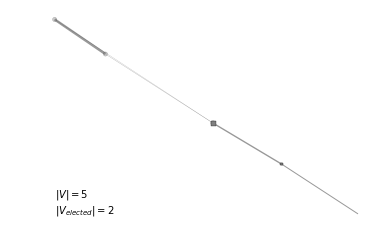

0.00027192506915032735 0.5
11.866654484500577 12.994930059883355


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.011794975126122143 0.5
11.654451564818022 12.151158395353214


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


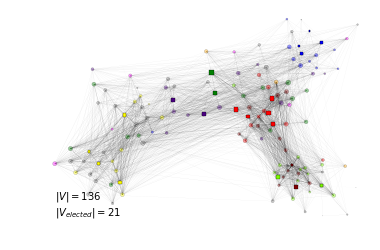

0.010399733784468613 0.5
12.466073264824209 12.864505674713483


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.0032098759104322804 0.5
12.460853216369216 12.479455596975166


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


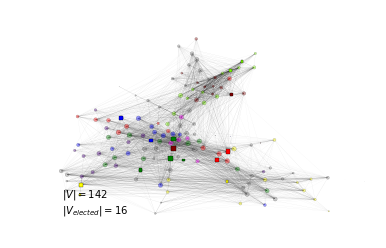

0.02902976691142355 0.5
12.200665122420462 11.27614070555737


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


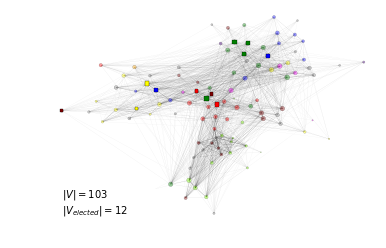

0.02092678029244522 0.5
12.82765606802054 12.49882175286099


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


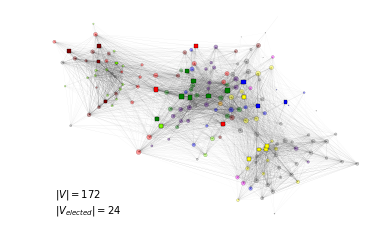

0.009045255611589713 0.5
12.05052708238468 12.29934824019156


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.018622564159682272 0.5
11.695087893156025 12.12958059954539


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


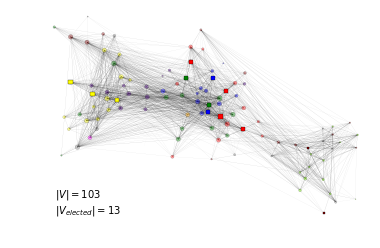

0.003876253220728614 0.5
11.780074939633954 12.006282849012305


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.001525891586819981 0.5
12.16151937723942 12.745936408338457


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.009916372912956956 0.5
10.978005507183562 11.600470165307089


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.015242657476288219 0.5
12.32337528100079 11.631954913313209


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [152]:
def get_party_colors(nodes):
    d_color = dict(zip(PARTIES,['gray','gray','gray','gray','gray',
            'green','blue', 'gray', 'indigo', 'gray', 'fuchsia',
            'yellow', 'gray', 'orange', 'red',
            'gray','gray', 'gray','gray','gray','maroon','lawngreen']))
    return [d_color[D[n][1]] for n in nodes]


for RIDX in range(13):    
    path = "graphs/"
    G=nx.read_edgelist(path+f"b0_n1_reg{RIDX}.edgelist")

    # print(G.edges(data=True))

    f_edges = sorted(G.edges(data=True),key= lambda x: x[2]['weight'])
    f_edges = f_edges[:len(f_edges)//1]

    mst = nx.minimum_spanning_tree(G)
    G = nx.create_empty_copy(G)
    G.add_edges_from(f_edges) # Filter half of edges
    G.add_edges_from(mst.edges(data=True))

    nodes = [int(n) for n in G.nodes()]
    
    pos = nx.kamada_kawai_layout(mst)
    
    #pos_arr = np.asarray(list(pos.values()))
    #pos = nx.rescale_layout(pos_arr,10)
    #pos = dict(zip([str(n) for n in nodes],pos))
    
    #a,b = zip(*pos.items())
    #pos = dict(zip(a,[[x,1.5*y] for x,y in b]))
    
    
    # print(pos)
    
    node_labels1 = [e(D,n) for n in nodes]
    # print(G.edges(data=True))

    edge_weights = [1-e[2]['weight'] for e in G.edges(data=True)]
    edge_weights = [0.15*w**10 for w in edge_weights]
    edge_weights = [w/(2*max(edge_weights)) for w in edge_weights]
    if len(edge_weights) < 100: edge_weights = [w*5 for w in edge_weights]

    print(min(edge_weights),max(edge_weights))
    nodecolors = get_party_colors(nodes)
    """
    nodesizes = [temp_d[n][4] for n in nodes] # Change between 3 --> 4 (eigenv, closeness)
    nodesizes = [ns-min(nodesizes) for ns in nodesizes]
    nodesizes = [ns/max(nodesizes) for ns in nodesizes]
    # nodesizes = [ns-0.5*min(nodesizes) for ns in nodesizes]
    nodesizes = [50*((ns**3)/max(nodesizes)) for ns in nodesizes]
    nodesizes = [ns+1 for ns in nodesizes]
    """
    
    nodesizes = [temp_d[n][3] for n in nodes] # Change between 3 --> 4 (eigenv, closeness)
    nodesizes = [ns-min(nodesizes) for ns in nodesizes]
    nodesizes = [ns/max(nodesizes) for ns in nodesizes]
    nodesizes = [ns*25 for ns in nodesizes]
    nodesizes = [ns for ns in nodesizes]
    
    
    
    a = np.asarray(nodesizes)
    print(np.mean(a),np.median(a))
    limits=plt.axis('off')

    # fig, ax = plt.subplots()
    #nx.draw_networkx_nodes(G,pos=pos,with_labels=False,node_size=[n*1.5 for n in nodesizes],node_color='black')
    nx.draw_networkx(G,pos=pos,width=edge_weights,with_labels=False,alpha=0.4,node_size=nodesizes,node_color=nodecolors,linewidths=0.3)
    
    # nx.draw_networkx_nodes(G,pos=pos,with_labels=False,node_size=nodesizes,node_color=nodecolors,edgecolors='black',lindewith=0.1)
    
    e_nodes = [str(n) for i,n in enumerate(nodes) if e(D,n)]
    e_nodecolors = [n for i,n in enumerate(nodecolors) if e(D,nodes[i])]
    e_nodesizes = [n for i,n in enumerate(nodesizes) if e(D,nodes[i])]
    
    #nx.draw_networkx_nodes(G,nodelist=e_nodes,pos=pos,with_labels=False,node_size=[n*1.5 for n in e_nodesizes],node_color='black',node_shape="s")
    nx.draw_networkx(G,nodelist=e_nodes,pos=pos,width=0,with_labels=False,linewidths=0.3,node_size=e_nodesizes,node_color=e_nodecolors,node_shape="s")
    
    ax = plt.gca() # to get the current axis
    ax.collections[0].set_edgecolor("#000000") 
    # print(ax.collections)
    ax.collections[2].set_edgecolor("#000000") 
    
    plt.annotate(f'$|V|={len(nodes)}$\n'+"$|V_{elected}|="+f'{len(e_nodes)}$', xy=(0.05, 0.05), xycoords='axes fraction')
    plt.savefig(f"figures/networks/rainbow{RIDX}_eigen.png",quality=100,dpi=1000,bbox_inches= 'tight',pad_inches=0)
    plt.show()
    
    
    


/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/monsu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


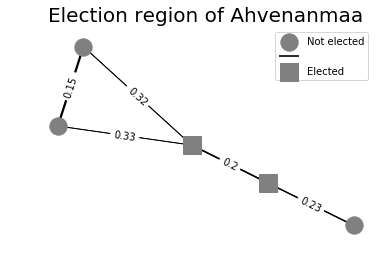

In [271]:
G=nx.read_edgelist(path+"b0_n1_reg0.edgelist")
elected_nodes = [n for n in G.nodes() if e(D,int(n))]
pos = nx.kamada_kawai_layout(G)
limits=plt.axis('off')
edge_weights = [5*(1-d['weight'])**5 for u,v,d in G.edges(data=True)]


nx.draw(G,pos,with_labels=False,width=edge_weights,node_color='gray',label="Not elected")

labels = nx.get_edge_attributes(G,'weight')
a,b = zip(*labels.items())
labels = dict(zip(a,[round(x,2) for x in b]))



nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)



nx.draw(G,pos,nodelist=elected_nodes,with_labels=False,node_color='gray',node_shape="s",label="Elected")

plt.title("Election region of Ahvenanmaa",size=20)
plt.legend(["Not elected",None,"Elected"])
plt.savefig("draw_connected_ahvenanmaa.pdf")